# 네이버 영화리뷰 감성분석 도전하기

### 라이브러리 import

In [1]:
import konlpy
import gensim
import pandas as pd
import os
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

### 함수 및 변수

In [2]:

# 사전 크기 및 차원
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원 수 

# 훈련 파일
train_file = '~/aiffel/sentiment_classification/data/ratings_train.txt'
test_file = '~/aiffel/sentiment_classification/data/ratings_test.txt'

# 워드벡터 파일
w2v_file1 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec1.txt'
w2v_file2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec2.txt'
w2v_file3 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec3.txt'
w2v_ko_file = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'

# 토크나이저
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 데이터 로더 (텍스트 전처리 및 인덱스 변환 & 인덱스 딕셔너리 제공 )
def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # 결측치 제거
    train_data.dropna(how = 'any', inplace=True)
    test_data.dropna(how = 'any', inplace=True)

    # 한글 외 제거 (감성 분석에는 !등이 의미가 있다고 하여 제거)
    # train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    # test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    
    # 토큰화
    X_train = train_data['document'].apply(tokenizer.morphs)
    X_test = test_data['document'].apply(tokenizer.morphs)
    
    # 불용어 제거
    X_train = X_train.apply(lambda x: [item for item in x if item not in stopwords]).tolist()
    X_test = X_test.apply(lambda x: [item for item in x if item not in stopwords]).tolist()


    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    # mecab은 내부적으로만 BOS등을 사용하고 반환 토큰에는 해당 내용이 없음 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# history 확인용 그래프 함수
def show_history_graph(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # "bo"는 "파란색 점"입니다
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()
    
# 학습된 임베딩 파라미터를 파일에 저장하는 함수
def save_word_vector(model, word2vec_file_path=""):
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

# 모델별 워드 벡터에서 유사 단어 찾는 함수
def similar_by_word_per_wv(wvs, word):
    result_dict = {}

    for model_name, wv in zip(wvs["model"], wvs["wv"]):
        if word in wv:
            similar_words = wv.similar_by_word(word, topn=7)  # 7개로 제한
            word_sim_list = [f"{w}-{round(sim, 4)}" for w, sim in similar_words]
        else:
            word_sim_list = [f"'{word}' not in vocab"]
        
        result_dict[model_name] = word_sim_list

    # 데이터프레임 생성
    df = pd.DataFrame.from_dict(result_dict, orient='index')

    # 열 이름을 1부터 시작하게 설정
    df.columns = [str(i) for i in range(1, len(df.columns)+1)]

    return df

## 데이터 준비 및 전처리 

In [3]:
# Raw 데이터 읽어서 확인
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 데이터 로딩 
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 인덱스별 단어 저장
index_to_word = {index:word for word, index in word_to_index.items()}

# 최대 토큰수 계산
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 평균 + 2*표준편차)로 계산하여 최대 토큰수 구함  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) * 100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# 계산된 최대 길이로 패딩 (pre 패딩 사용)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [6]:
# validation 용 데이터 따로 구성
num_val_set = X_train.shape[0]//5
print(num_val_set)

# validation set 
x_val = X_train[:num_val_set]   
y_val = y_train[:num_val_set]

# validation set을 제외한 나머지 
partial_x_train = X_train[num_val_set:]  
partial_y_train = y_train[num_val_set:]

print(partial_x_train.shape)
print(partial_y_train.shape)

29236
(116946, 41)
(116946,)


## 모델 준비

- Conv1D with MaxPooling, LSTM, 양방향 LSTM 세가지 모델 준비
- 최종 단계에 dense layer 두개 공통 적용 (16차원 relu -> 1차원 sigmoid )
- dense layer 사이에만 dropout 레이어 적용

In [7]:
# Conv1D with MaxPooling

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(4))
model1.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          14368     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [8]:
# LSTM

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(32))
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 652,961
Trainable params: 652,961
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 양방향 LSTM

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 665,889
Trainable params: 665,889
Non-trainable params: 0
_________________________________________________________________


# 모델 훈련
- 20 번 epochs를 적용하여 훈련하였으나 항상 10이하에서 과대적합이 발생
- 여러가지 테스트를 수행하면서 수행 시간 단축을 위해 early_stop 적용 (이전 과정 분석시 문제 없을 것으로 판단 )
- 몇몇 파라미터를 변경하면서 테스트를 하였으나 최종 훈련 과정만 기록 
- 한글 외 토큰을 제외하여 문장 구성을 변경하였으나 감성 분석에는 느낌표등 분석에 도움이 된다는 내용을 보고 느낌표 마침표등 토큰이 포함되도록 함


In [10]:
# Conv1D with MaxPooling

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 6s 5ms/step - loss: 0.5211 - accuracy: 0.7256 - val_loss: 0.4248 - val_accuracy: 0.7896
Epoch 2/20
457/457 [==============================] - 2s 5ms/step - loss: 0.4084 - accuracy: 0.8167 - val_loss: 0.4122 - val_accuracy: 0.7985
Epoch 3/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3540 - accuracy: 0.8450 - val_loss: 0.4217 - val_accuracy: 0.8019
Epoch 4/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2870 - accuracy: 0.8776 - val_loss: 0.4672 - val_accuracy: 0.7902
Epoch 5/20
457/457 [==============================] - 2s 5ms/step - loss: 0.2282 - accuracy: 0.9041 - val_loss: 0.5552 - val_accuracy: 0.7861


In [11]:
# LSTM

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 5s 6ms/step - loss: 0.4353 - accuracy: 0.8062 - val_loss: 0.3471 - val_accuracy: 0.8481
Epoch 2/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3421 - accuracy: 0.8606 - val_loss: 0.3357 - val_accuracy: 0.8529
Epoch 3/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3074 - accuracy: 0.8742 - val_loss: 0.3433 - val_accuracy: 0.8537
Epoch 4/20
457/457 [==============================] - 3s 6ms/step - loss: 0.2795 - accuracy: 0.8870 - val_loss: 0.3438 - val_accuracy: 0.8555
Epoch 5/20
457/457 [==============================] - 3s 6ms/step - loss: 0.2537 - accuracy: 0.8972 - val_loss: 0.3685 - val_accuracy: 0.8550


In [12]:
# 양방향 LSTM
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 7s 9ms/step - loss: 0.4550 - accuracy: 0.7926 - val_loss: 0.3477 - val_accuracy: 0.8494
Epoch 2/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3448 - accuracy: 0.8607 - val_loss: 0.3341 - val_accuracy: 0.8544
Epoch 3/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3087 - accuracy: 0.8759 - val_loss: 0.3421 - val_accuracy: 0.8576
Epoch 4/20
457/457 [==============================] - 3s 8ms/step - loss: 0.2799 - accuracy: 0.8880 - val_loss: 0.3414 - val_accuracy: 0.8582
Epoch 5/20
457/457 [==============================] - 3s 8ms/step - loss: 0.2549 - accuracy: 0.8980 - val_loss: 0.3765 - val_accuracy: 0.8566


## 모델 훈련 결과

- 두가지 LSTM 에서 비슷하게 좋은 결과를 볼 수 있지만 85% 달성 실패
- 1D Conv는 LSTM에 비해 아쉬운 결과로 80%를 넘지 못함

In [13]:
# Conv1D with MaxPooling
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.4188 - accuracy: 0.7961
[0.4188392460346222, 0.7961022853851318]


In [14]:
# LSTM
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 3s - loss: 0.3438 - accuracy: 0.8474
[0.34381917119026184, 0.8474276065826416]


In [15]:
# 양방향 LSTM
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 4s - loss: 0.3427 - accuracy: 0.8492
[0.342651903629303, 0.8492178320884705]


## Loss, Accuracy 그래프 시각화
- Conv1D 의 경우 LSTM보다 validation loss가 증가하는 기울기가 더 빠른 것을 볼 수 있음
 -> 과대 적합이 더 빠르게 된다고 판단된다. 데이터 순서에 대한 반영이 다르기때문으로 보임
 

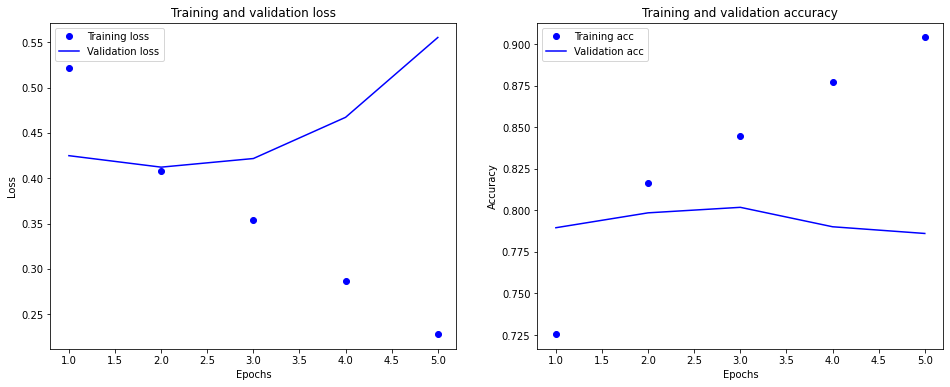

In [16]:
# # Conv1D with MaxPooling
show_history_graph(history1)

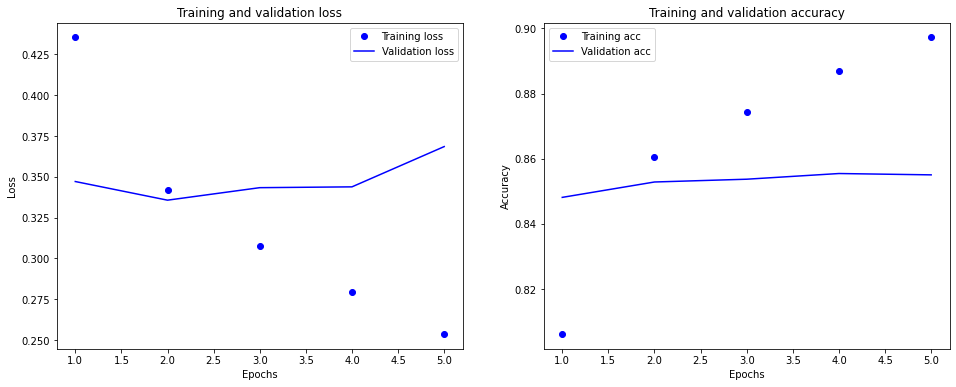

In [17]:
# LSTM
show_history_graph(history2)

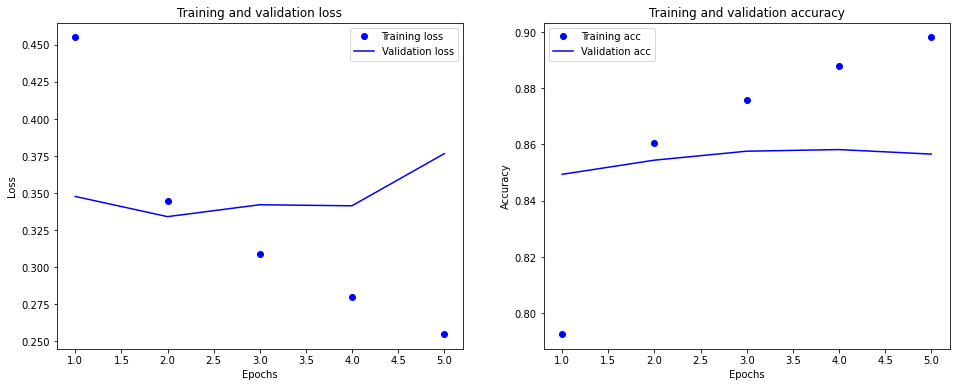

In [18]:
# 양방향 LSTM
show_history_graph(history3)

## 학습된 Embedding 레이어 분석
- 자체 학습된 데이터는 리뷰라는 특수 상황만을 반영했기 때문에 의미적 유사성이 일반적이지 않은 것으로 보인다. 영화 평가와 관련이 없는 단어의 경우는 왜 유사 단어로 묶였는지 이해하기 어려운 부분이 많다. 영화 평가와 관련된 단어의 경우 그런 평가의 리뷰를 쓸 때 사용될 수 있는 단어들이 유사 단어로 분류되고 있으나 일반적인 의미에서 유사한 단어는 아닌 경우가 많다.
- 사전 학습된 모델의 경우는 계절은 계절끼리 가족관계는 가족관계끼리 그리고 영화 장르도 영화 장르끼리 유사하게 묶여 관계적 분류에 따라서 유사 단어로 되거나 의미적인 부분에서 유사한 부분으로 어느정도 이해가 가는 유사 단어를 보여준다.
- 영화 리뷰 분류 작업이라는 특수성이 있으므로 자체 학습 데이터가 무의미한 것은 아닌 것으로 보이나 사전 학습 모델의 의미를 추가해준다면 일반화 성능이 높아질 것으로 기대해 볼 수 있겠다.


In [19]:
# 워드 벡터 분석 준비

# 모델별 워드 벡터 파일 저장
save_word_vector(model1, w2v_file1)
save_word_vector(model2, w2v_file2)
save_word_vector(model3, w2v_file3)

# 모델별 워드 벡터 로드
wv1 = Word2VecKeyedVectors.load_word2vec_format(w2v_file1, binary=False)
wv2 = Word2VecKeyedVectors.load_word2vec_format(w2v_file2, binary=False)
wv3 = Word2VecKeyedVectors.load_word2vec_format(w2v_file3, binary=False)

# 사전 정의된 워드 벡터 로드
wv_ko = Word2VecKeyedVectors.load(w2v_ko_file)

wvs = {"model" : ["Conv1D","LSTM","Bi-LSTM","wv_ko"], "wv":[wv1,wv2, wv3, wv_ko.wv] }

# similar_by_word_per_wv 함수 정의는 위에 

In [20]:
similar_by_word_per_wv(wvs, "동생")

,1,2,3,4,5,6,7
Conv1D,긍정-0.5178,줄-0.5047,한방-0.4853,책-0.467,결국-0.4475,냉정-0.4259,나레이션-0.4233
LSTM,싱크-0.4955,이래저래-0.4305,나눠서-0.4253,어-0.4225,압박-0.4124,수상-0.3829,웨슬리-0.3739
Bi-LSTM,제길-0.5501,집착-0.5322,짜증-0.5218,톰-0.515,ㅡㅜ-0.5095,숫-0.5032,오죽-0.5024
wv_ko,조카-0.9233,아들-0.8791,외삼촌-0.8787,남동생-0.8766,친형-0.8748,이복동생-0.8748,삼촌-0.8712


In [21]:
similar_by_word_per_wv(wvs, "봄")

,1,2,3,4,5,6,7
Conv1D,ㅎㅎ-0.8441,이제야-0.822,탄탄-0.821,가히-0.8204,미소-0.8194,흠뻑-0.8187,입가-0.8181
LSTM,남긴다-0.7448,엄청-0.7365,봐도-0.7349,채워-0.7269,잼-0.722,모임-0.7201,흘러가-0.7097
Bi-LSTM,이웃-0.7832,봐도-0.7759,수수-0.7592,숫자-0.7435,흘러가-0.7361,물질-0.7322,행동-0.7314
wv_ko,가을-0.9201,여름-0.8531,겨울-0.8039,초여름-0.7416,늦여름-0.7038,늦가을-0.6825,초겨울-0.6319


In [22]:
similar_by_word_per_wv(wvs,"최악")

,1,2,3,4,5,6,7
Conv1D,아까움-0.9489,아까-0.9478,헛웃음-0.9468,느니-0.9445,개뿔-0.9436,돌렸-0.9435,그닥-0.9434
LSTM,낚였-0.9721,조악-0.9709,하품-0.9672,낭비-0.9667,boring-0.9663,유치원생-0.9632,부실-0.9628
Bi-LSTM,낭비-0.9744,그다지-0.97,짝퉁-0.9694,조악-0.9678,개콘-0.9657,차라리-0.9648,하품-0.9648
wv_ko,전대미문-0.647,초유-0.629,최고-0.6104,희대-0.5654,뜻밖-0.56,엄청난-0.5393,최저-0.5323


In [23]:
similar_by_word_per_wv(wvs,"최상")

,1,2,3,4,5,6,7
Conv1D,신들린-0.8834,귀여워-0.8621,틈-0.8593,프렌즈-0.8551,뿌듯-0.8539,미소-0.8516,웰메이드-0.8512
LSTM,쵝오-0.8722,헌신-0.8714,정윤희-0.8707,유쾌-0.8634,레전드-0.8572,틈-0.8565,감독판-0.8559
Bi-LSTM,손색-0.9072,뗄-0.8818,후편-0.8814,훈훈-0.8788,웃겨요-0.8772,살아가-0.8747,귀여워-0.8744
wv_ko,올바른-0.6504,본연-0.6309,최적-0.6016,개개인-0.575,최선-0.5638,제고-0.5471,양질-0.5419


In [24]:
similar_by_word_per_wv(wvs,"코미디")

,1,2,3,4,5,6,7
Conv1D,둔-0.5084,칼-0.4835,상속자-0.4824,마이너-0.4706,특공대-0.4695,안중근-0.4402,희대-0.4369
LSTM,세기-0.5227,편승-0.449,심지어-0.4426,실력-0.4236,단막극-0.4218,핑-0.4216,단조로운-0.4125
Bi-LSTM,실소-0.697,빡-0.6836,...;;;-0.6628,독수리-0.6582,더러워-0.6532,망친다-0.6523,진부-0.6517
wv_ko,스릴러-0.8268,드라마-0.7935,미스터리-0.7878,로맨스-0.7693,영화-0.7489,액션-0.743,로맨틱-0.7338


## 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 기존 3개의 모델에 사전 훈련된 임베딩 적용 


In [25]:
# 사전 정의 모델의 임베딩 단어 차원 확인 - 100 차원
wv_ko.wv.vectors.shape


(302960, 100)

### 임베딩 메트릭스 생성

In [26]:

word_vector_dim = wv_ko.wv.vectors.shape[1]   # 워드 벡터의 차원수 ( 가져온 모델의 차원수로 변경)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in wv_ko.wv:
        embedding_matrix[i] = wv_ko.wv[index_to_word[i]]

### 모델 준비 (한국어 Word2Vec 임베딩 적용)

In [27]:
# Conv1D with MaxPooling
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model4.add(tf.keras.layers.MaxPooling1D(4))
model4.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model4.add(tf.keras.layers.GlobalMaxPooling1D())
model4.add(tf.keras.layers.Dense(16, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 32)             7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [28]:
# LSTM
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model5.add(tf.keras.layers.LSTM(32))
model5.add(tf.keras.layers.Dense(16, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,017,569
Trainable params: 1,017,569
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 양방향 LSTM
model6 = tf.keras.Sequential()
model6.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model6.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model6.add(tf.keras.layers.Dense(16, activation='relu'))
model6.add(tf.keras.layers.Dropout(0.5))
model6.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,035,105
Trainable params: 1,035,105
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 (한국어 Word2Vec 임베딩 적용)

In [30]:
# Conv1D with MaxPooling
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 3s 6ms/step - loss: 0.6457 - accuracy: 0.6147 - val_loss: 0.5590 - val_accuracy: 0.7092
Epoch 2/20
457/457 [==============================] - 2s 5ms/step - loss: 0.5387 - accuracy: 0.7281 - val_loss: 0.5041 - val_accuracy: 0.7503
Epoch 3/20
457/457 [==============================] - 2s 5ms/step - loss: 0.4853 - accuracy: 0.7622 - val_loss: 0.4663 - val_accuracy: 0.7685
Epoch 4/20
457/457 [==============================] - 2s 5ms/step - loss: 0.4496 - accuracy: 0.7844 - val_loss: 0.4530 - val_accuracy: 0.7777
Epoch 5/20
457/457 [==============================] - 2s 5ms/step - loss: 0.4229 - accuracy: 0.8036 - val_loss: 0.4441 - val_accuracy: 0.7855
Epoch 6/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3975 - accuracy: 0.8164 - val_loss: 0.4647 - val_accuracy: 0.7738
Epoch 7/20
457/457 [==============================] - 2s 5ms/step - loss: 0.3770 - accuracy: 0.8257 - val_loss: 0.4488 - val_accuracy: 0.7852
Epoch 

In [31]:
# LSTM
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history5 = model5.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 4s 6ms/step - loss: 0.5309 - accuracy: 0.7317 - val_loss: 0.3940 - val_accuracy: 0.8239
Epoch 2/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3941 - accuracy: 0.8332 - val_loss: 0.3504 - val_accuracy: 0.8486
Epoch 3/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3492 - accuracy: 0.8567 - val_loss: 0.3408 - val_accuracy: 0.8498
Epoch 4/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3241 - accuracy: 0.8690 - val_loss: 0.3350 - val_accuracy: 0.8538
Epoch 5/20
457/457 [==============================] - 3s 6ms/step - loss: 0.3029 - accuracy: 0.8786 - val_loss: 0.3349 - val_accuracy: 0.8572
Epoch 6/20
457/457 [==============================] - 3s 6ms/step - loss: 0.2882 - accuracy: 0.8861 - val_loss: 0.3407 - val_accuracy: 0.8571
Epoch 7/20
457/457 [==============================] - 3s 6ms/step - loss: 0.2747 - accuracy: 0.8916 - val_loss: 0.3358 - val_accuracy: 0.8583
Epoch 

In [32]:
# 양방향 LSTM
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history6 = model6.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                     callbacks=[early_stop])

Epoch 1/20
457/457 [==============================] - 7s 9ms/step - loss: 0.5232 - accuracy: 0.7362 - val_loss: 0.3954 - val_accuracy: 0.8208
Epoch 2/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3925 - accuracy: 0.8336 - val_loss: 0.3571 - val_accuracy: 0.8409
Epoch 3/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3498 - accuracy: 0.8549 - val_loss: 0.3406 - val_accuracy: 0.8505
Epoch 4/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3212 - accuracy: 0.8690 - val_loss: 0.3379 - val_accuracy: 0.8533
Epoch 5/20
457/457 [==============================] - 3s 8ms/step - loss: 0.3010 - accuracy: 0.8783 - val_loss: 0.3350 - val_accuracy: 0.8554
Epoch 6/20
457/457 [==============================] - 4s 8ms/step - loss: 0.2854 - accuracy: 0.8866 - val_loss: 0.3376 - val_accuracy: 0.8573
Epoch 7/20
457/457 [==============================] - 3s 8ms/step - loss: 0.2709 - accuracy: 0.8932 - val_loss: 0.3480 - val_accuracy: 0.8552
Epoch 

### 훈련 결과 확인 (한국어 Word2Vec 임베딩 적용)
- Conv1D의 경우 오히려 결과가 안좋아짐 정확하진 않으나 순서에 대한 반영이 떨어지는 conv1d의 특성으로 인한 것이 아닐까 생각됨
- LSTM 의 경우 85% 달성하였으나 정확도 향상이 기대보다는 떨어짐 
- 낮은 향상의 원인 및 개선까지 하고싶었으나 시간부족 (LMS에 잘 적용하면 5% 향상된다고 써있어서...)

In [33]:
# Conv1D with MaxPooling
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 3s - loss: 0.4527 - accuracy: 0.7799
[0.45274078845977783, 0.7799092531204224]


In [34]:
# LSTM
results5 = model5.evaluate(X_test,  y_test, verbose=2)

print(results5)

1537/1537 - 3s - loss: 0.3452 - accuracy: 0.8539
[0.3452270030975342, 0.8539373874664307]


In [35]:
# 양방향 LSTM
results6 = model6.evaluate(X_test,  y_test, verbose=2)

print(results6)

1537/1537 - 4s - loss: 0.3426 - accuracy: 0.8542
[0.34258806705474854, 0.8542425036430359]


### Loss, Accuracy 그래프 시각화
- 모든 그래프에서 과적합되는 기울기가 줄어든 것을 확인할 수 있다.
 -> 일반화가 더 잘될 것이라는 예상이 맞는 것으로 보인다.
 

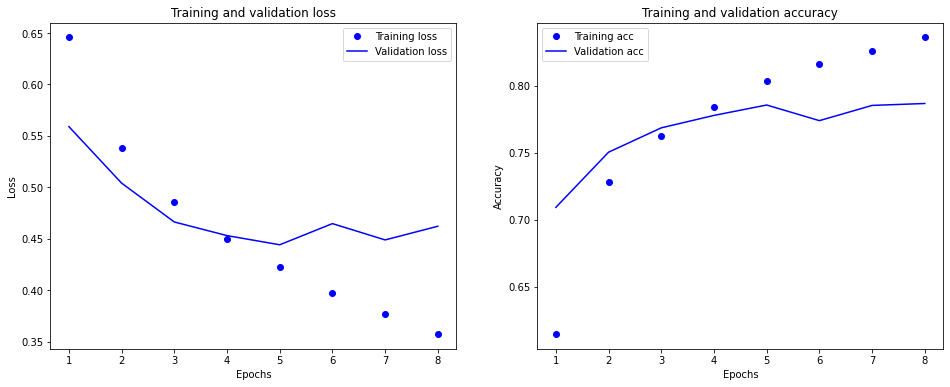

In [36]:
# Conv1D with MaxPooling
show_history_graph(history4)

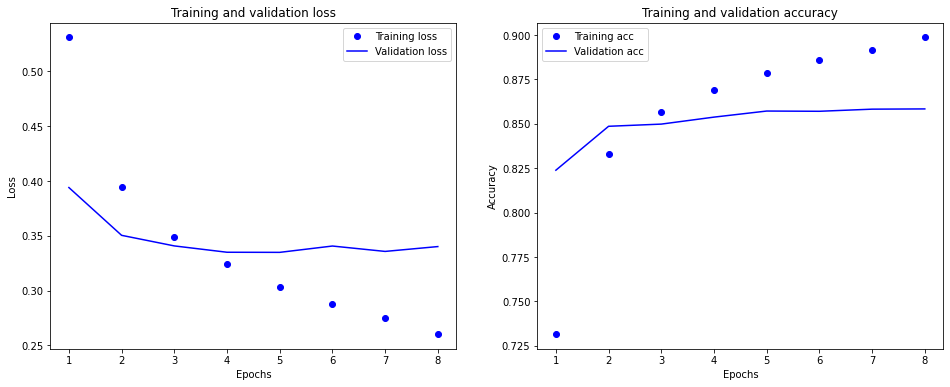

In [37]:
# LSTM
show_history_graph(history5)

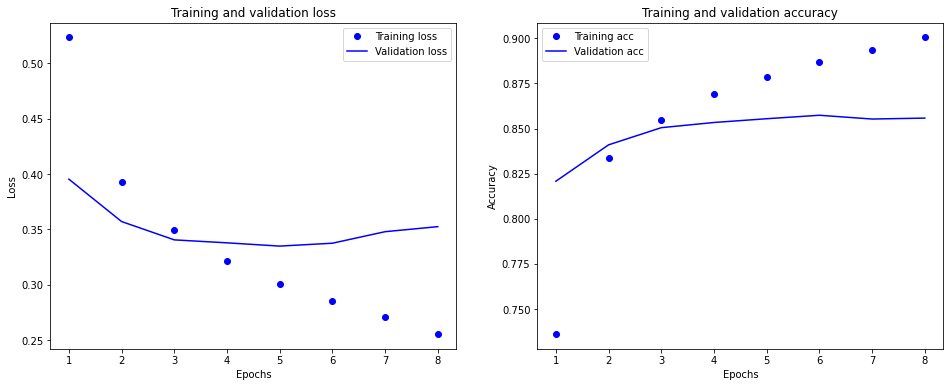

In [39]:
# 양방향 LSTM
show_history_graph(history6)

## 회고

생각보다 자체학습 모델의 정확도가 높았다고 생각된다. 몇번 안되는 훈련으로 과접합이될만큼 학습 속도가 빨랐다. 회고를 작성하면서 든 생각이 학습률 조정을 해볼걸 하는 생각을 해본다. 프로젝트 시작할때는 뭔가 막막했는데 다 하고나니 그래도 텍스트 분류 모델에 대해 조금은 이해도가 올라간것 같다. 모델을 향상하는 작업은 아직 어려운 것 같다. 학습 노드에서는 확인할 부분들이 주어져 있어서 해결할 수 있었지만 실제로 어떤 부분을 확인하고 어떤 부분을 처리해야되는지 여전히 잘 모른다고 느낀다. 아직 아는게 적은만큼 더 배우다보면 알게되지 않을까 생각한다. 